In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
import numpy as np
import pandas as pd
import warnings
from copy import deepcopy
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2, gaussian_kde
from scipy.special import erfinv, erf
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sns

from settings import poles, many_colors
from tools import get_mids
from aeff_calculations import energy_smearing, aeff_eval_e_sd
from fluxes import (
    atmo_background,
    astro_flux,
    plot_spectrum,
    power_law,
    cut_off,
    parabola_index,
)


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [3]:
from glob import glob
e_smearing_files = sorted(glob("../resources/*energy_smearing_kde.pckl"))

In [4]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")


# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)

logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")


40 log_10(energy) bins
50 declination bins


# Background

In [6]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))


# Energy smearing with KDE

## Load matrices

In [22]:
# energy smearing matrix
with open("../resources/energy_smearing_kde.pckl", "rb") as f:
    normed_kvals, logE_reco_bins = pickle.load(f)
# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)
logE_reco_mids = get_mids(logE_reco_bins)

# # artificial smearing matrix
# with open("../resources/artificial_energy_smearing_kde.pckl", "rb") as f:
#     artificial_normed_kvals, _ = pickle.load(f)

# artificial, improved smearing matrix
with open("../resources/improved_0.1_artificial_energy_smearing_kde.pckl", "rb") as f:
    artificial_normed_kvals, _ = pickle.load(f)

## original

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

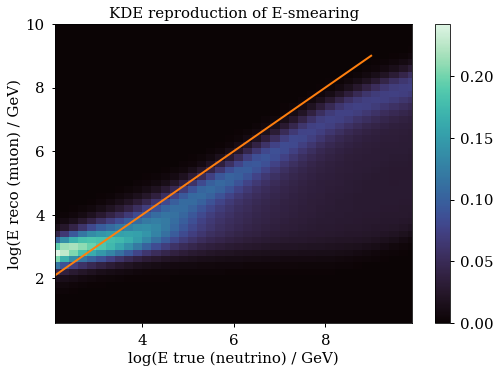

In [8]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

plt.grid(False)
plt.pcolormesh(egrid_true, egrid_reco, normed_kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(egrid_reco), np.max(egrid_reco))
plt.xlim(np.min(egrid_true), np.max(egrid_true))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


## Artificial energy resolution

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

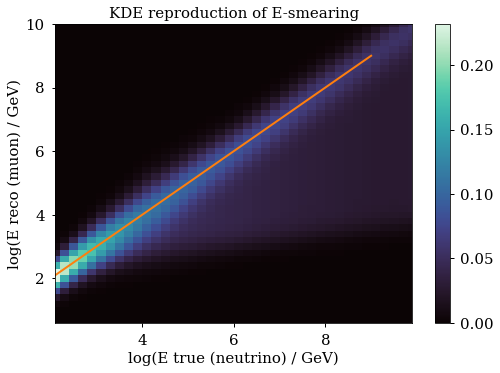

In [9]:
plt.grid(False)
plt.pcolormesh(egrid_true, egrid_reco, artificial_normed_kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(egrid_reco), np.max(egrid_reco))
plt.xlim(np.min(egrid_true), np.max(egrid_true))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

### NGC1068 - source parameters

In [10]:
from settings import ngc1068

In [11]:
# find the right lower bin boundary/ bin index for NGC1068's declination
ngc_bin_index = np.digitize(np.sin(ngc1068.dec.rad), sindec_bins)
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600
LIVETIME = lt_kde = 3186 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 #3
E0_NGC = 1E3
# PHI_NGC = PHI_PS * (E_NORM / 1e3) ** (-GAMMA_NGC)  # -> 2E-20

gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
phi_c_68 /= 1E11
#gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")

# analysis region in distance to source
delta_psi = 2

## alternative shapes: source parameters

In [20]:
# parabola parameters
Alpha_NGC = 1
Beta_NGC = 1
E_para_norm = 3E2

# cutoff parameters
Gamma_cut = 2.0
logE_cut = 3.7 # log10 (Ecut / GeV)

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
phi_c_68 /= 1E11

# energy range of the ngc spectrum
# mask1 = emids >= 1.5E3
# mask1 &= emids <= 1.5E4



### scale the fluxes such that the event numbers match


In [21]:
aeff_factor_signal = aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth
astro_ev_sum_pl = np.sum(
    astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)

# parabola
astro_ev_sum_para = np.sum(
    astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm,
        Alpha_NGC,
        1,
        Beta_NGC,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)
# match event numbers
flux_scaling_para = astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        1,
        logE_cut,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut)


flux_scaling_para 6.306920083888016
flux_scaling_cut 0.9818890434364221



### Plot flux and event expectation


powerlaw with cutoff 87.15826960742777
power law: 87.1582696074278


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


powerlaw with cutoff 87.15826960742777
power law: 87.1582696074278


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


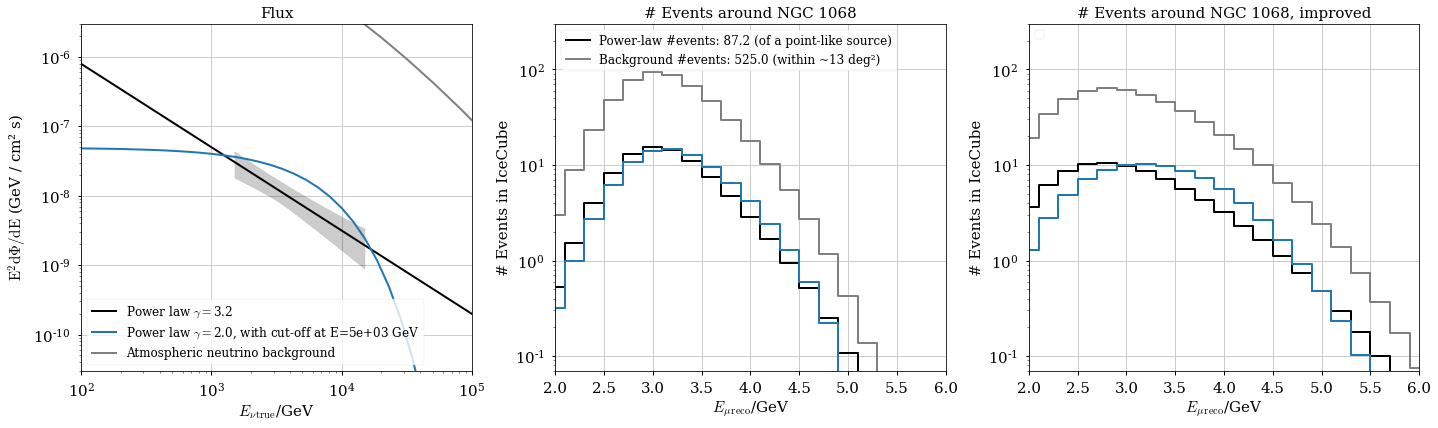

In [26]:
sq_deg = np.pi * delta_psi**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, E0_NGC, GAMMA_NGC, PHI_NGC)
cut = power_law(x_evals, E0_NGC, Gamma_cut, PHI_NGC * flux_scaling_cut) * cut_off(
    x_evals, 10**logE_cut
)
#para_idx = parabola_index(Alpha_NGC, Beta_NGC, x_evals, E_para_norm)
#para = power_law(x_evals, E_para_norm, para_idx, PHI_NGC * flux_scaling_para)

f, axes = plt.subplots(ncols=3, figsize=(20, 6))
ax = axes[0]
ax.set_title("Flux")

# error contour
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont, c_low * (x_cont**y_scaling), c_high * (x_cont**y_scaling), color="k", alpha=0.2
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
)

#ax.plot(x_evals, para * (x_evals**y_scaling), label="Log-Parabola", color="darkred")
ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${Gamma_cut}, with cut-off at E={10**logE_cut:1.0e} GeV",
    color="tab:blue",
)
ax.plot(
    emids,
    spl_vals[ngc_bin_index] * (emids**y_scaling),
    label="Atmospheric neutrino background",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(3e-11, 3e-6)
#ax.set_ylim(3e-6, 1e-3)
ax.set_xlim(1e2, 1e5)
ax.legend(loc=3, fontsize=12)


### plot Event numbers in E_reco
for ii, nkv in enumerate([normed_kvals, artificial_normed_kvals]):
    ax = axes[1+ii]
    ident = "IceCube"
    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    use_e_reco = True
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg, spl_vals[ngc_bin_index], normed_kvals=nkv
    )

    # # parabola
    # k_s_par = astro_flux(
    #     "parabola",
    #     aeff_factor_signal,
    #     emids,
    #     E_para_norm,
    #     Alpha_NGC,
    #     flux_scaling_para,
    #     Beta_NGC,
    #     normed_kvals=nkv,
    #     phi_0=PHI_NGC,
    # )
    # print("parabola:", np.sum(k_s_par))

    # cutoff
    k_s_cut = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        normed_kvals=nkv,
        phi_0=PHI_NGC,
    )
    print("powerlaw with cutoff", np.sum(k_s_cut))

    # powerlaw
    k_s_pl = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        normed_kvals=nkv,
        phi_0=PHI_NGC,
    )
    print("power law:", np.sum(k_s_pl))

    evals = logE_reco_mids
    _ = plot_spectrum(
        evals,
        [
            k_s_pl,
            #k_s_par,
            k_s_cut,
            k_b,
        ],
        [
            f"Power-law #events: {np.sum(k_s_pl):1.1f} (of a point-like source)" if ii==0 else "",
            #"",
            "",
            f"Background #events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)" if ii==0 else "",
        ],
        "# Events around NGC 1068" if ii==0 else "# Events around NGC 1068, improved",
        f,
        ax,
        xlim=(2, 6),
        ylim=(7e-2, 3e2),
        color=["k", "tab:blue", "gray"], #"darkred", 
        xlabel=r"$E_{\mu \, \rm reco}$/GeV",
        ylabel="# Events in IceCube",
    )
    ax.legend(loc=2, fontsize=12)


## Test event numbers -- full sky

In [16]:
from settings import E_NORM, GAMMA_ASTRO, PHI_ASTRO

In [17]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
)
astro_ev = astro_flux(
    "powerlaw",
    aeff_factor,
    emids,
    E_NORM,
    GAMMA_ASTRO,
    1,
    phi_0=PHI_ASTRO,
    smear_energy=False,
)
print(
    "original sum astro:",
    np.sum(astro_ev),
    "smeared sum astro:",
    np.sum(energy_smearing(normed_kvals, astro_ev)),
    "artificially smeared sum astro:",
    np.sum(energy_smearing(artificial_normed_kvals, astro_ev)),
    # should be numerically the same
)


original sum astro: 2039.59780874495 smeared sum astro: 2039.59780874495 artificially smeared sum astro: 2039.5978087449498


# NGC 1068

### Expected energy distribution

(10, 10000000.0)

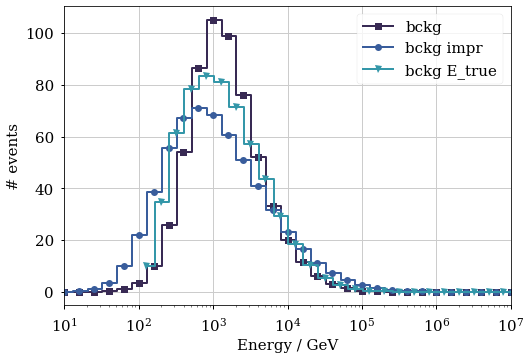

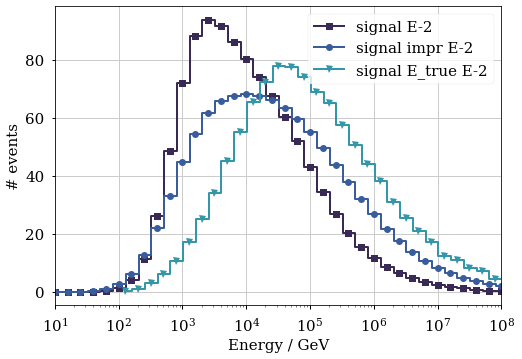

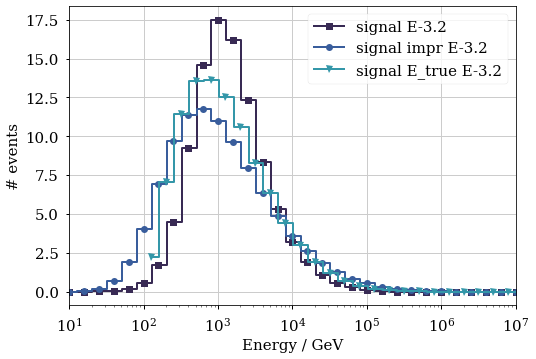

In [18]:
# we only need the (average) effective area at the location of NGC1068
# since the solid angle of this analysis is small enough
# background expectation

aeff_factor = (
    aeff_2d["IceCube"][:, ngc_bin_index]
    * lt_10yr
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
)

plt.figure()
plt.plot(
    10 ** (logE_reco_mids),
    atmo_background(aeff_factor, spl_vals[ngc_bin_index], normed_kvals=normed_kvals),
    label="bckg",
    drawstyle="steps-mid",
    marker="s",
)
plt.plot(
    10 ** (logE_reco_mids),
    atmo_background(
        aeff_factor, spl_vals[ngc_bin_index], normed_kvals=artificial_normed_kvals
    ),
    label="bckg impr",
    drawstyle="steps-mid",
    marker="o",
)
plt.plot(
    10 ** (logE_mids),
    atmo_background(
        aeff_factor, spl_vals[ngc_bin_index], smear_energy=False
    ),
    label="bckg E_true",
    drawstyle="steps-mid",
    marker="v",
)

plt.xscale("log")
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Energy / GeV")
plt.xlim(10, 1E7)

# signal
plt.figure()
# calculate events per ngc pixel with newest 'science' NGC1068 flux
aeff_factor = aeff_2d["IceCube"][:, ngc_bin_index] * lt_10yr * ewidth
# flux is already integrated over solid angle, because it's a point source
plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 2, 1, phi_0=PHI_NGC, normed_kvals=normed_kvals),
    label="signal E-2",
    drawstyle="steps-mid",
    marker="s",
)

plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 2, 1, phi_0=PHI_NGC, normed_kvals=artificial_normed_kvals),
    label="signal impr E-2",
    drawstyle="steps-mid",
    marker="o",
)

plt.plot(
    10 ** (logE_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 2, 1, phi_0=PHI_NGC, smear_energy=False),
    label="signal E_true E-2",
    drawstyle="steps-mid",
    marker="v",
)

plt.xscale("log")
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Energy / GeV")
plt.xlim(10, 1E8)

plt.figure()
# calculate events per ngc pixel with newest 'science' NGC1068 flux
aeff_factor = aeff_2d["IceCube"][:, ngc_bin_index] * lt_10yr * ewidth
# flux is already integrated over solid angle, because it's a point source
plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 3.2, 1, phi_0=PHI_NGC, normed_kvals=normed_kvals),
    label="signal E-3.2",
    drawstyle="steps-mid",
    marker="s",
)

plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 3.2, 1, phi_0=PHI_NGC, normed_kvals=artificial_normed_kvals),
    label="signal impr E-3.2",
    drawstyle="steps-mid",
    marker="o",
)

plt.plot(
    10 ** (logE_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 3.2, 1, phi_0=PHI_NGC, smear_energy=False),
    label="signal E_true E-3.2",
    drawstyle="steps-mid",
    marker="v",
)

plt.xscale("log")
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Energy / GeV")
plt.xlim(10, 1E7)

# PSF-Energy functions from the smearing matrix
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$

In [16]:
public_data_hist = np.genfromtxt("../resources/IC86_II_smearing.csv", skip_header=1)

logE_sm_min, logE_sm_max = public_data_hist[:, 0], public_data_hist[:, 1]
logE_sm_mids = (logE_sm_min + logE_sm_max) / 2.0
dec_sm_min, dec_sm_max = public_data_hist[:, 2], public_data_hist[:, 3]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0
log_psf_min, log_psf_max = np.log10(public_data_hist[:, 6]), np.log10(
    public_data_hist[:, 7]
)
psf_mids = (public_data_hist[:, 6] + public_data_hist[:, 7]) / 2.0
log_psf_mids = np.log10(psf_mids)
fractional_event_counts = public_data_hist[:, 10]


## Full 2D psi-energy LLH of NGC 1068

In [17]:
## set up the psi2-energy function and binning
mask = dec_sm_mids == 0
e_psi_kdes = gaussian_kde(
    (logE_sm_mids[mask], log_psf_mids[mask]), weights=fractional_event_counts[mask]
)

# psi² representation
delta_psi = 2
bins_per_psi2 = 25
psi2_bins = np.linspace(0, delta_psi**2, delta_psi**2 * bins_per_psi2 + 1)
psi2_mids = get_mids(psi2_bins)
log_psi_mids = np.log10(np.sqrt(psi2_mids))
# KDE was produced in log(E_true) and log(Psi)
e_eval, psi_eval = np.meshgrid(logE_mids, log_psi_mids)
psi_kvals = e_psi_kdes([e_eval.flatten(), psi_eval.flatten()]).reshape(
    len(log_psi_mids), len(logE_mids)
)

# new grid for analysis in psi^2 and e_reco after energy smearing
e_grid, psi_grid = np.meshgrid(logE_mids, psi2_mids)
e_psi2_grid = psi_kvals / psi_grid / 2 / np.log(10)
# normalize per energy to ensure that signal event numbers are not changed
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)


## Set up LLH function

In [18]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0_NGC,
    phi_0=PHI_NGC,
    shape="powerlaw",
    normed_kvals=normed_kvals,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0], spl_vals[ngc_bin_index], normed_kvals=normed_kvals
    )
    mu_s = astro_flux(
        shape, mu_s_base, emids, e_0, *x[1:], phi_0=phi_0, normed_kvals=normed_kvals
    )
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )
 

### Significance test Background vs. Background + Signal

In [22]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))
    # fix signal contribution to 0
    local_llh = lambda x: ps_llh_2d_composite(
        (x[0], 3, 0), mu_b_base, mu_s_base, k_i
    )
    global_llh = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i
    )
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("")

    # plt.figure()
    # plt.title(ident)
    # plt.plot(psi2_mids, np.sum(k_s, axis=-1), ds="steps-mid", label="Signal expectation")
    # plt.plot(psi2_mids, np.sum(k_b, axis=-1), ds="steps-mid", label="Uniform bckg expectation")
    # plt.xlabel(r"($\Psi$/deg)²")
    # plt.ylabel("events per bin")
    # plt.xlim(0, 4)
    # #plt.ylim(0, 13)
    # plt.legend()



IceCube
Asimov data sum:
Background: 524.9763541658032
Signal: 87.15826960742777
Atmo-only normalization: [1.16602345]
Signal fit parameters: [1.00000379 3.20000267 0.99998924]
-2 Delta LLH: 19.346359297211166
P-VALUE: 6.294937987431622e-05 SIGNIFICANCE: 4.001472997415365

Plenum-1
Asimov data sum:
Background: 2088.4842798146415
Signal: 348.5257154538155
Atmo-only normalization: [1.16687975]
Signal fit parameters: [1.00000509 3.19999048 0.99996243]
-2 Delta LLH: 73.59306197753904
P-VALUE: 1.0458505723074971e-16 SIGNIFICANCE: inf

Plenum-2
Asimov data sum:
Background: 5488.621682507806
Signal: 913.0275070004765
Atmo-only normalization: [1.16634923]
Signal fit parameters: [0.99999904 3.19998637 0.99996488]
-2 Delta LLH: 198.87754928119102
P-VALUE: 6.520619919798714e-44 SIGNIFICANCE: inf



### Significance test Background vs. Background + Signal with improved energy resolution

In [23]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    for ef in e_smearing_files:
        # energy smearing matrix
        with open(ef, "rb") as f:
            nkv, _ = pickle.load(f)
        # normalize per bin in true energy
        nkv = nkv / np.sum(nkv, axis=0)
        es_ident = ef.split("/")[-1].split("_energy")[0]
        print(es_ident)
        
        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index], normed_kvals=nkv)
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC, normed_kvals=nkv
        )
        k_i = k_s + k_b

        # print("Asimov data sum:")
        # print("Background:", np.sum(k_b))
        # print("Signal:", np.sum(k_s))

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        local_llh = lambda x: ps_llh_2d_composite(
            (x[0], 3, 0),
            mu_b_base,
            mu_s_base,
            k_i, normed_kvals=nkv
        )
        # background + signal, 3 free parameters
        global_llh = lambda x: ps_llh_2d_composite(
            x, mu_b_base, mu_s_base, k_i, normed_kvals=nkv
        )
        # ... and fit both hypotheses!
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        print("Atmo-only normalization:", out_bckg[0])

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        print("Signal fit parameters:", out_comp[0])
        # print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        # calculate p-value and significance with Wilks'
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("")



IceCube
artificial
Atmo-only normalization: [1.16602394]
Signal fit parameters: [1.00000305 3.19999746 0.9999869 ]
P-VALUE: 6.680386037053917e-05 SIGNIFICANCE: 3.9873910679586544

energy_smearing_kde.pckl
Atmo-only normalization: [1.16602345]
Signal fit parameters: [1.00000379 3.20000267 0.99998924]
P-VALUE: 6.294937987431622e-05 SIGNIFICANCE: 4.001472997415365

idealized_artificial
Atmo-only normalization: [1.16602268]
Signal fit parameters: [0.99999089 3.19999536 0.99997646]
P-VALUE: 4.7968937078043646e-05 SIGNIFICANCE: 4.065308649992731

improved_0.05_artificial
Atmo-only normalization: [1.16602353]
Signal fit parameters: [0.99998834 3.19999563 0.99997718]
P-VALUE: 4.7546772435933055e-05 SIGNIFICANCE: 4.06736973106256

improved_0.1_artificial
Atmo-only normalization: [1.16602316]
Signal fit parameters: [0.99998562 3.19998877 0.99998544]
P-VALUE: 4.715878165008655e-05 SIGNIFICANCE: 4.06927932813442

improved_0.2_artificial
Atmo-only normalization: [1.16602356]
Signal fit parameters: 

## 1D scan of power-law parameters

In [22]:
idents = ["IceCube", "Plenum-1", "Plenum-2", "Gen-2"]
num = 50
gamma_astro_scaling = np.linspace(2.5, 3.8, num=num + 1)
astro_scaling = np.logspace(-1.5, 0.3, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL_gamma_scan = {"ts": {}, "conv": {}, "phi_astro": {}}
local_SPL_phi_scan = {"ts": {}, "conv": {}, "gamma": {}}
shape = "powerlaw"

for ident in idents:
    print(ident)
    for kvi in ["standard", "improved"]:
        print(kvi)
        kv = normed_kvals if kvi=="standard" else artificial_normed_kvals

        aeff_factor_bckg = (
            aeff_2d[ident][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid
        if "Plenum" in ident:
            aeff_factor_bckg += (
                aeff_2d["IceCube"][:, ngc_bin_index]
                * LIVETIME
                * ewidth
                * (np.deg2rad(delta_psi) ** 2)
                * np.pi  # solid angle approx.
            ) * bckg_grid

        aeff_factor_signal = (
            aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
        if "Plenum" in ident:
            aeff_factor_signal += (
                aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
            )
        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index], normed_kvals=kv)
        k_s = astro_flux(
            "powerlaw", aeff_factor_signal, emids, E0_NGC, GAMMA_NGC, 1, phi_0=PHI_NGC, normed_kvals=kv
        )
        k_i = k_s + k_b

        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))

        ## global minimum
        global_llh = lambda x: ps_llh_2d_composite(
            x, mu_b_base, mu_s_base, k_i, normed_kvals=kv
        )
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 2.8, 1.2),
            approx_grad=True,
        )
        if out[2]["warnflag"] != 0:
            print("WARNING!!")
        print("bf param:", out[0])

        bf_SPL["ts"][ident + kvi] = out[1]
        bf_SPL["conv"][ident + kvi] = out[0][0]
        bf_SPL["gamma"][ident + kvi] = out[0][1]
        bf_SPL["phi_astro"][ident + kvi] = out[0][2]

        print("starting local gamma scan...")
        local_SPL_gamma_scan["ts"][ident + kvi] = np.zeros(len(gamma_astro_scaling))
        local_SPL_gamma_scan["conv"][ident + kvi] = np.zeros(len(gamma_astro_scaling))
        local_SPL_gamma_scan["phi_astro"][ident + kvi] = np.zeros(len(gamma_astro_scaling))
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed gamma
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], gas, x[1]), mu_b_base, mu_s_base, k_i, normed_kvals=kv
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2),
                bounds=[(0.1, 3), (0.1, 3)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL_gamma_scan["conv"][ident + kvi][j], local_SPL_gamma_scan["phi_astro"][ident + kvi][j] = local_out[0]
            local_SPL_gamma_scan["ts"][ident + kvi][j] = local_out[1]

        print("starting local phi scan...")
        local_SPL_phi_scan["ts"][ident + kvi] = np.zeros(len(astro_scaling))
        local_SPL_phi_scan["conv"][ident + kvi] = np.zeros(len(astro_scaling))
        local_SPL_phi_scan["gamma"][ident + kvi] = np.zeros(len(astro_scaling))
        for j, asc in enumerate(astro_scaling):
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], x[1], asc), mu_b_base, mu_s_base, k_i, normed_kvals=kv
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 2.8),
                bounds=[(0.1, 3), (1, 6)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL_phi_scan["conv"][ident + kvi][j], local_SPL_phi_scan["gamma"][ident + kvi][j]= local_out[0]
            local_SPL_phi_scan["ts"][ident + kvi][j] = local_out[1]
        print("done")
        print("")


IceCube
standard
Asimov data sum:
Background: 601.8278832251033
Signal: 99.91740863596021
bf param: [0.99989935 3.20028378 1.00005021]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:
Background: 601.8278832251034
Signal: 99.91740863596021
bf param: [1.0000184  3.20006726 1.00001215]
starting local gamma scan...
starting local phi scan...
done

Plenum-1
standard
Asimov data sum:
Background: 2394.2184505947894
Signal: 399.54655465270434
bf param: [0.99999821 3.20014408 1.00005085]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:
Background: 2394.2184505947885
Signal: 399.5465546527043
bf param: [0.99999646 3.19999458 0.99998704]
starting local gamma scan...
starting local phi scan...
done

Plenum-2
standard
Asimov data sum:
Background: 6292.103525797712
Signal: 1046.6860221495729
bf param: [0.99999899 3.20001349 1.00001709]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:

In [23]:
sns.set_palette("Paired", n_colors=8)

Text(0, 0.5, '-2$\\Delta$LLH')

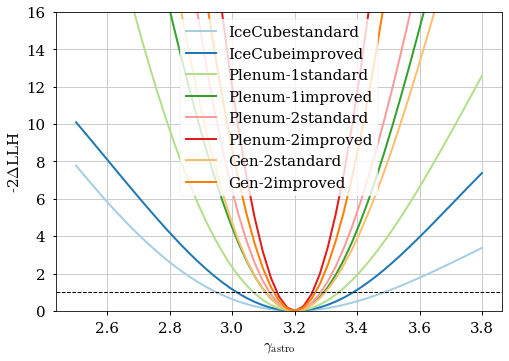

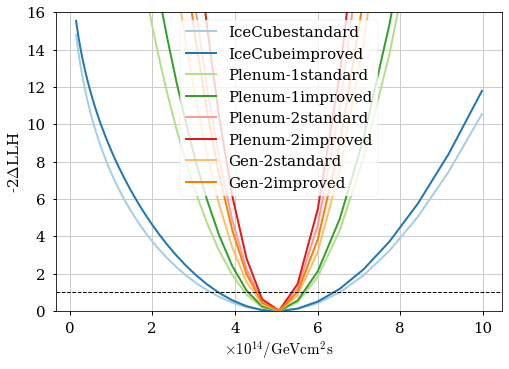

In [24]:
plt.figure()
for ident in local_SPL_gamma_scan["ts"].keys(): #idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_gamma_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        gamma_astro_scaling[mask],
        local_SPL_gamma_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
#plt.xlim(2.1, 2.4)
plt.legend(loc="upper center")
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

plt.figure()
for ident in local_SPL_phi_scan["ts"].keys(): #idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_phi_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        astro_scaling[mask] * (PHI_NGC * 1E14),
        local_SPL_phi_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
plt.legend(loc="upper center")
plt.xlabel(r"$\times 10^{14} / \rm GeV cm^2 s$")
plt.ylabel(r"-2$\Delta$LLH")


## 2D scan - parameters of 10yr PS Paper

IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 99.91740863596021
bf param: [0.99989935 3.20028378 1.00005021]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 399.54655465270434
bf param: [0.99999821 3.20014408 1.00005085]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797712
Signal: 1046.6860221495729
bf param: [0.99999899 3.20001349 1.00001709]
starting local fits...
done
IceCube
Plenum-1
Plenum-2


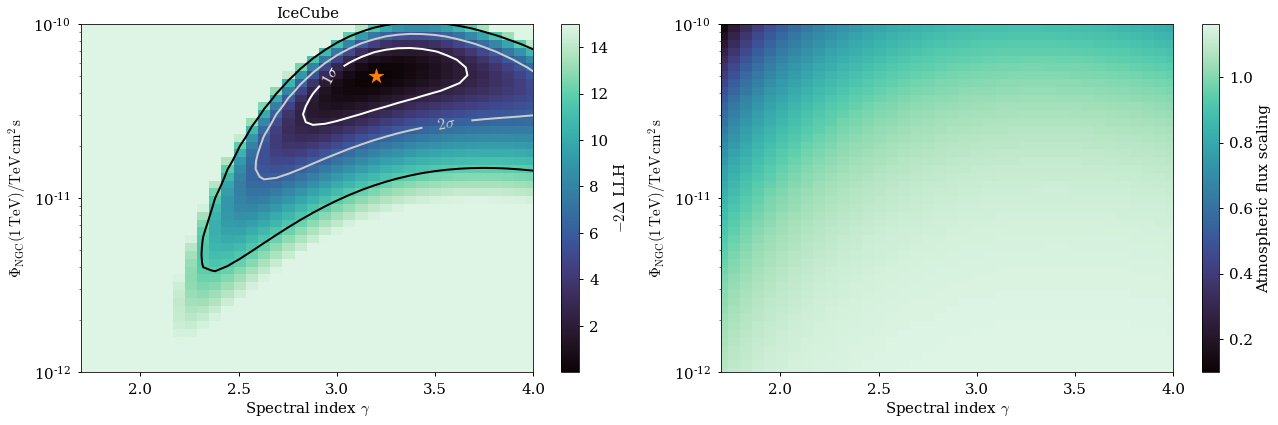

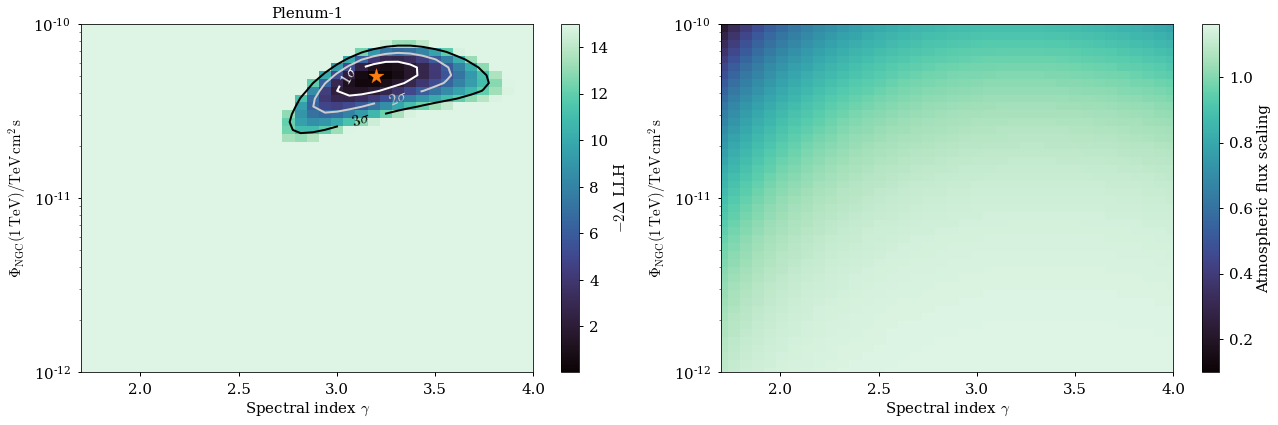

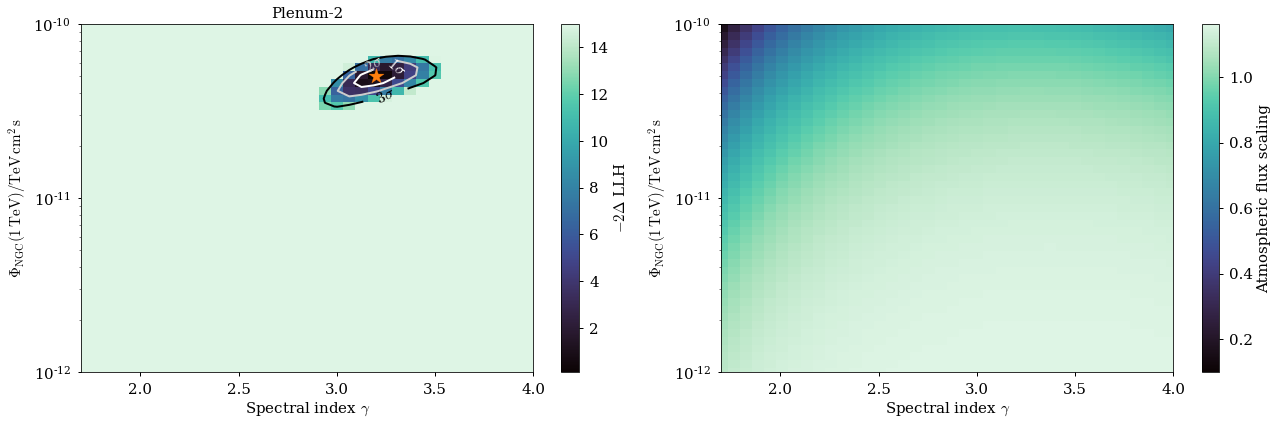

In [25]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.7, 4.8, num=num + 1)
astro_scaling = np.logspace(-1.7, 0.5, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL = {"ts": {}, "conv": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw", aeff_factor_signal, emids, E0_NGC, GAMMA_NGC, 1, phi_0=PHI_NGC
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    out = fmin_l_bfgs_b(
        ps_llh_2d_composite,
        x0=(1.2, 2.8, 1.2),
        approx_grad=True,
        args=(mu_b_base, mu_s_base, k_i),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed gamma and phi_astro
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], gas, asc), mu_b_base, mu_s_base, k_i
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                bounds=[(0.1, 3)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (local_SPL["conv"][ident][i][j],) = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


ref_color = "tab:orange"
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["gamma"][ident],
        bf_SPL["phi_astro"][ident]
        * PHI_NGC
        * 1e3,  # match 10yr paper plot of Tessa C.
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    # ax.plot(
    #     diffuse_10yr_ref[:, 0],
    #     diffuse_10yr_ref[:, 1],
    #     color=ref_color,
    #     label=r"9.5yr IC diffuse $\nu_\mu$, 95% CL",
    # )
    # ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


# Power law vs. Other shapes
## Power-law with cutoff -- Significance
### normal vs. improved E resolution

In [157]:
# livetime relative to 10yrs
detector_configurations = [
{"idx":  0, "identifier": "10y IC", "e_file": '../resources/artificial_energy_smearing_kde.pckl', "E_res": "baseline"},
{"idx":  1, "identifier": "10y IC", "e_file": '../resources/idealized_artificial_energy_smearing_kde.pckl', "E_res": "idealized"},
{"idx":  2, "identifier": "10y IC", "e_file": '../resources/improved_0.1_artificial_energy_smearing_kde.pckl', "E_res": "10% improv."},
{"idx":  3, "identifier": "10y IC", "e_file": '../resources/improved_0.5_artificial_energy_smearing_kde.pckl', "E_res": "50% improv."},
{"idx":  4, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/artificial_energy_smearing_kde.pckl', "E_res": "baseline"},
{"idx":  5, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/idealized_artificial_energy_smearing_kde.pckl', "E_res": "idealized"},
{"idx":  6, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.1_artificial_energy_smearing_kde.pckl', "E_res": "10% improv."},
{"idx":  7, "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.5_artificial_energy_smearing_kde.pckl', "E_res": "50% improv."},
{"idx":  8, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/artificial_energy_smearing_kde.pckl', "E_res": "baseline"},
{"idx":  9, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/idealized_artificial_energy_smearing_kde.pckl', "E_res": "idealized"},
{"idx": 10, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.1_artificial_energy_smearing_kde.pckl', "E_res": "10% improv."},
{"idx": 11, "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.5_artificial_energy_smearing_kde.pckl', "E_res": "50% improv."},
]
detector_configurations = pd.DataFrame(detector_configurations)

In [158]:
pvals = []
for (identifier, es_ident), series in detector_configurations.groupby(
    ["identifier", "E_res"]
):
    print(es_ident, identifier)
    aeff_factor_bckg = (
        aeff_2d["IceCube"][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth
    if "PL-1" in identifier:
        ikey = "Plenum-1"
    elif "PL-2" in identifier:
        ikey = "Plenum-2"
    else:
        ikey = False
    if ikey:
        aeff_factor_bckg += (
            aeff_2d[ikey][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        aeff_factor_signal += aeff_2d[ikey][:, ngc_bin_index] * LIVETIME * ewidth

    aeff_factor_bckg = aeff_factor_bckg * bckg_grid
    aeff_factor_signal = aeff_factor_signal * e_psi2_grid

    for ef in series.e_file:
        print(ef)
        # energy smearing matrix
        with open(ef, "rb") as f:
            nkv, _ = pickle.load(f)
        # normalize per bin in true energy
        nkv = nkv / np.sum(nkv, axis=0)
        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg, spl_vals[ngc_bin_index], normed_kvals=nkv
        )
        k_s = astro_flux(
            "powerlaw with cutoff",
            aeff_factor_signal,
            emids,
            E0_NGC,
            Gamma_cut,
            flux_scaling_cut,
            logE_cut,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
        )
        k_i = k_s + k_b

        if ii == 0:
            print(
                "Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s)
            )
        pl_func = lambda x: ps_llh_2d_composite(
            x, mu_b_base, mu_s_base, k_i, shape="powerlaw", normed_kvals=nkv
        )
        out_bckg = fmin_l_bfgs_b(
            pl_func,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        print("bckg params:", out_bckg[0])

        # factor our the args because it's ugly the way I programmed it (:
        comp = lambda x: ps_llh_2d_composite(
            x,
            mu_b_base,
            mu_s_base,
            k_i,
            e_0=E0_NGC,
            shape="powerlaw with cutoff",
            normed_kvals=nkv,
        )
        out_comp = fmin_l_bfgs_b(
            comp,
            x0=(1.2, 1.9, 1.1, 3.4),
            approx_grad=True,
        )
        print("global params:", out_comp[0])
        print("true params:", (1, Gamma_cut, flux_scaling_cut, logE_cut))

        # check the LLH at the "correct" parameter position
        check = comp((1, Gamma_cut, flux_scaling_cut, logE_cut))
        pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
        pval_check = chi2.sf(out_bckg[1] - check, 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("pval check:", pval_check, "ratio:", pval_check / pval)
        print("")
        pvals.append(
            {
                "identifier": identifier,
                "e_smearing": es_ident,
                "idx": series.idx.values[0],
                "pval": pval,
                r"Significance in $\sigma$": significance,
            }
        )


10% improv. 10y IC
../resources/improved_0.1_artificial_energy_smearing_kde.pckl
Asimov data sum: Background = 524.9763541658031 , Signal = 87.15826960742777
bckg params: [0.98997242 2.99227211 0.96534428]
global params: [1.00215824 1.85616459 0.96947622 3.62972277]
true params: (1, 2.0, 0.9818890434364221, 3.7)
P-VALUE: 0.11674451409324672 SIGNIFICANCE: 1.5685856680235046
pval check: 0.11603838108430369 ratio: 0.9939514673179501

50% improv. 10y IC
../resources/improved_0.5_artificial_energy_smearing_kde.pckl
Asimov data sum: Background = 524.976354165803 , Signal = 87.15826960742775
bckg params: [0.98990408 2.99252355 0.96588519]
global params: [1.00231285 1.8653487  0.9661468  3.63507011]
true params: (1, 2.0, 0.9818890434364221, 3.7)
P-VALUE: 0.08921885780365496 SIGNIFICANCE: 1.6995327047853201
pval check: 0.08866393317089452 ratio: 0.9937801867629636

baseline 10y IC
../resources/artificial_energy_smearing_kde.pckl
Asimov data sum: Background = 524.9763541658032 , Signal = 87.1582

# Nice significance summary plot

In [159]:
pval_df = pd.DataFrame(pvals).sort_values("idx")

In [160]:
pval_df

,identifier,e_smearing,idx,pval,Significance in $\sigma$
2,10y IC,baseline,0,4.293606e-01,0.790286
3,10y IC,idealized,1,1.278176e-01,1.522765
0,10y IC,10% improv.,2,1.167445e-01,1.568586
1,10y IC,50% improv.,3,8.921886e-02,1.699533
6,10y IC + 10y PL-1,baseline,4,1.311542e-01,1.509566
7,10y IC + 10y PL-1,idealized,5,3.391640e-03,2.929815
4,10y IC + 10y PL-1,10% improv.,6,2.547460e-03,3.017646
5,10y IC + 10y PL-1,50% improv.,7,1.080207e-03,3.268758
10,10y IC + 10y PL-2,baseline,8,1.176492e-02,2.519118
11,10y IC + 10y PL-2,idealized,9,1.105770e-06,4.871816


In [161]:
### only 95% contours
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {"colors": [poles["Plenum-1"]["color"]], "linestyles": poles["Plenum-1"]["ls"]},
    "Plenum-2": {"colors": [poles["Plenum-2"]["color"]], "linestyles": poles["Plenum-2"]["ls"]},
}

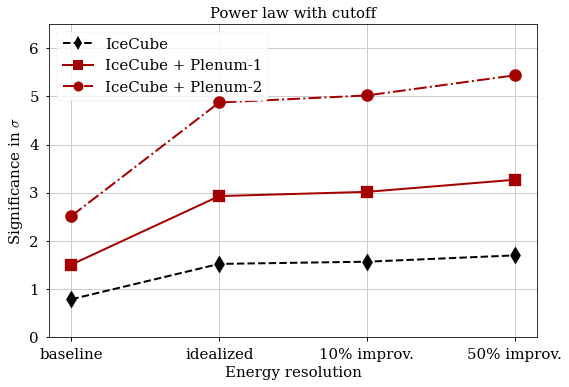

In [162]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
mask = pval_df.identifier == "10y IC"
ax.plot(
    pval_df.loc[mask]["e_smearing"],
    pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
    marker="d",
    label="IceCube",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["e_smearing"],
    y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["IceCube"]["color"],
    s=150,
    zorder=10,
    marker="d",
)


# ax.text(
#     x=pval_df.loc[0]["identifier"],
#     y=pval_df.loc[0][r"Significance in $\sigma$"],
#     s="  10yr",
#     fontsize=label_size,
# )
# ax.text(
#     x=pval_df.loc[1]["identifier"],
#     y=pval_df.loc[1][r"Significance in $\sigma$"],
#     s="  +10yr",
#     fontsize=label_size,
# )
# ax.text(
#     x=pval_df.loc[2]["identifier"],
#     y=pval_df.loc[2][r"Significance in $\sigma$"],
#     s="  +30yr",
#     fontsize=label_size,
# )

## PLENUM-1
mask = pval_df.identifier == "10y IC + 10y PL-1"
ax.plot(
    pval_df.loc[mask]["e_smearing"],
    pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
    marker="s",
    label="IceCube + Plenum-1",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["e_smearing"],
    y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["Plenum-1"]["color"],
    s=150,
    zorder=10,
    marker="s",
)
# ax.text(
#     x=pval_df.loc[3]["identifier"],
#     y=pval_df.loc[3][r"Significance in $\sigma$"],
#     s="  +2yr",
#     fontsize=label_size,
# )
# ax.text(
#     x=pval_df.loc[4]["identifier"],
#     y=pval_df.loc[4][r"Significance in $\sigma$"],
#     s="  +5yr",
#     fontsize=label_size,
# )
# ax.text(
#     x=pval_df.loc[5]["identifier"],
#     y=pval_df.loc[5][r"Significance in $\sigma$"],
#     s="  +10yr",
#     fontsize=label_size,
# )


## PLENUM-2
mask = pval_df.identifier == "10y IC + 10y PL-2"
ax.plot(
    pval_df.loc[mask]["e_smearing"],
    pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
    marker="o",
    label="IceCube + Plenum-2",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[mask]["e_smearing"],
    y=pval_df.loc[mask][r"Significance in $\sigma$"],
    c=poles["Plenum-2"]["color"],
    s=150,
    zorder=10,
    marker="o",
)
# ax.text(
#     x=pval_df.loc[6]["identifier"],
#     y=pval_df.loc[6][r"Significance in $\sigma$"],
#     s="  +2yr",
#     fontsize=label_size,
# )
# ax.text(
#     x=pval_df.loc[7]["identifier"],
#     y=pval_df.loc[7][r"Significance in $\sigma$"],
#     s="  +5yr",
#     fontsize=label_size,
# )
# ax.text(
#     x=pval_df.loc[8]["identifier"],
#     y=pval_df.loc[8][r"Significance in $\sigma$"],
#     s="  +10yr",
#     fontsize=label_size,
# )

#ax.set_xlim(-1, 10)
ax.set_ylim(0, 6.5)
#plt.xticks(rotation=-15, ha="center")
ax.legend(loc=2) #fontsize="x-small")
ax.set_title("Power law with cutoff")#, fontsize="small")
ax.set_xlabel("Energy resolution")
ax.set_ylabel(r"Significance in $\sigma$")
plt.tight_layout()
# plt.savefig("../plots/cutoff_sigma_vs_det_talk.pdf")


# Cross check with toy model fitting

In [27]:
from scipy.stats import poisson

In [28]:
ef = '../resources/energy_smearing_kde.pckl'
# energy smearing matrix
with open(ef, "rb") as f:
    nkv, logE_reco_bins = pickle.load(f)
# normalize per bin in true energy
nkv = nkv / np.sum(nkv, axis=0)
logE_reco_mids = get_mids(logE_reco_bins)
es_ident = ef.split("/")[-1].split("_energy")[0]
print(es_ident)

energy_smearing_kde.pckl


In [29]:
# idents = ["IceCube", "Plenum-1", "Plenum-2"] #, "Gen-2"]
ident = "Plenum-1"
print(ident)

aeff_factor_bckg = (
    aeff_2d[ident][:, ngc_bin_index]
    * LIVETIME
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
) * bckg_grid
if "Plenum" in ident:
    aeff_factor_bckg += (
        aeff_2d["IceCube"][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid

aeff_factor_signal = (
    aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
)
if "Plenum" in ident:
    aeff_factor_signal += (
        aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    
# model expectation for fitting
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg, spl_vals[ngc_bin_index], normed_kvals=nkv
)
k_s = astro_flux(
    "powerlaw",
    aeff_factor_signal,
    emids,
    E0_NGC,
    GAMMA_NGC,
    1,
    phi_0=PHI_NGC,
    normed_kvals=nkv,
)
k_baseline = k_s + k_b

num = 100
ts = np.zeros(num)
ts_check = np.zeros(num)

for ii in range(num):
    k_i = poisson.rvs(k_baseline)

    pl_func = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i, shape="powerlaw", normed_kvals=nkv
    )
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 3.0, 1.2),
        bounds=((0.2, 12), (1, 5), (0.2, 12)),
        approx_grad=True,
    )
    #print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(
        x,
        mu_b_base,
        mu_s_base,
        k_i,
        e_0=E0_NGC,
        shape="powerlaw with cutoff",
        normed_kvals=nkv,
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 2.2, 1, 3.3),
        bounds=((0.2, 12), (1, 5), (0.2, 4), (1, 20)),
        approx_grad=True,
    )
    #print("global params:", out_comp[0])
    #print("true params (background hypothesis):", (1, GAMMA_NGC, 1))

    # check the LLH at the "correct" parameter position
    ts[ii] = pl_func((1, GAMMA_NGC, 1)) - out_comp[1]
    ts_check[ii] = out_bckg[1] - out_comp[1]
    #pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    #pval_check = chi2.sf(out_bckg[1] - check, 1)
    #significance = erfinv(1 - pval) * np.sqrt(2)
    #print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    #print("pval check:", pval_check, "ratio:", pval_check / pval)
    #print("")


Plenum-1


<AxesSubplot:ylabel='Count'>

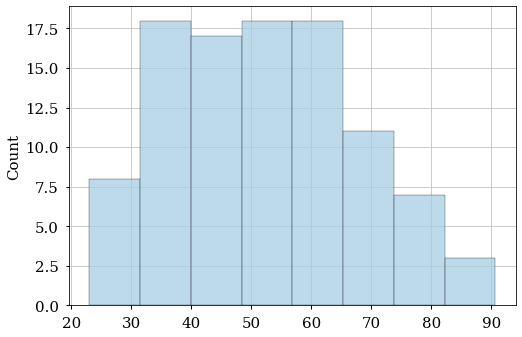

In [30]:
sns.histplot(ts)

<AxesSubplot:ylabel='Count'>

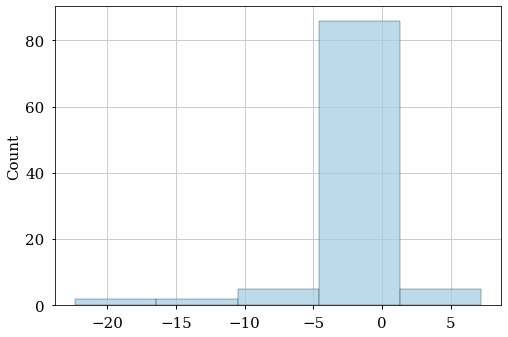

In [31]:
sns.histplot(ts_check, bins=5)

## Parabola -- Significance

In [24]:
idents = ["IceCube", "Plenum-1", "Plenum-2", "Gen-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    for ii, ef in enumerate(e_smearing_files):
        # energy smearing matrix
        with open(ef, "rb") as f:
            nkv, logE_reco_bins = pickle.load(f)
        # normalize per bin in true energy
        nkv = nkv / np.sum(nkv, axis=0)
        logE_reco_mids = get_mids(logE_reco_bins)
        es_ident = ef.split("/")[-1].split("_energy")[0]
        print(es_ident)
        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg, spl_vals[ngc_bin_index], normed_kvals=nkv
        )
        k_s = astro_flux(
            "parabola",
            aeff_factor_signal,
            emids,
            E_para_norm,
            Alpha_NGC,
            flux_scaling_para,
            Beta_NGC,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
        )
        k_i = k_s + k_b
        if ii == 0:
            print("Asimov Background:", np.sum(k_b), "Signal:", np.sum(k_s))

        global_llh = lambda x: ps_llh_2d_composite(
            x, mu_b_base, mu_s_base, k_i, normed_kvals=nkv
        )
        out_bckg = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        print("PL-only fit", out_bckg[0])

        # factor our the args because it's ugly the way I programmed it (:
        comp = lambda x: ps_llh_2d_composite(
            x,
            mu_b_base,
            mu_s_base,
            k_i,
            e_0=E_para_norm,
            shape="parabola",
            normed_kvals=nkv,
        )
        out_comp = fmin_l_bfgs_b(
            comp,
            x0=(1.2, 1.2, 0.05, 2.2),
            approx_grad=True,
        )
        print("global fit", out_comp[0])
        print("true params:", (1, Alpha_NGC, flux_scaling_para, Beta_NGC))

        pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

        check = comp((1, Alpha_NGC, flux_scaling_para, Beta_NGC))
        pval_check = chi2.sf(out_bckg[1] - check, 1)
        print("pval check:", pval_check, "ratio:", pval_check / pval)
        print("")


IceCube
artificial
Asimov Background: 601.8278832251034 Signal: 99.9174086359602
PL-only fit [0.97749344 3.19845066 1.13530886]
global fit [1.00090312 0.77872141 5.00791494 1.10527969]
true params: (1, 1, 6.3069200838880155, 1)
P-VALUE: 0.44311756558114357 SIGNIFICANCE: 0.7669393681107406
pval check: 0.4428879005833224 ratio: 0.9994817064010542

energy_smearing_kde.pckl
PL-only fit [0.98588447 3.09572179 1.04647149]
global fit [1.00104327 0.69516164 4.64210294 1.15005905]
true params: (1, 1, 6.3069200838880155, 1)
P-VALUE: 0.35949323609825257 SIGNIFICANCE: 0.916331147379297
pval check: 0.3589098379184381 ratio: 0.9983771650722936

idealized_artificial
PL-only fit [0.99167409 3.02793358 0.97776133]
global fit [1.00200678 0.66540612 4.47212799 1.16391633]
true params: (1, 1, 6.3069200838880155, 1)
P-VALUE: 0.09633545239033792 SIGNIFICANCE: 1.6628850256756202
pval check: 0.09559671204505069 ratio: 0.9923315837839848

improved_0.05_artificial
PL-only fit [0.99170007 3.02777662 0.97754004]


## cutoff - 2D scan

In [33]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1, 4, num=num + 1)
cut_scaling = np.linspace(3.0, 5.0, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}, "cut": {}}
local_SPL = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    comp = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i, e_0=E0_NGC, shape="powerlaw with cutoff"
    )
    out = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 2.2, 0.5, 4.1),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    bf_SPL["cut"][ident] = out[0][3]

    local_SPL["ts"][ident] = np.zeros((num + 1, num))
    local_SPL["conv"][ident] = np.zeros((num + 1, num))
    local_SPL["phi_astro"][ident] = np.zeros((num + 1, num))
    print("starting local fits...")
    for j, csc in enumerate(cut_scaling):
        for i, gsc in enumerate(gamma_astro_scaling):
            func = lambda x: ps_llh_2d_composite(
                (x[0], gsc, x[1], csc),
                mu_b_base,
                mu_s_base,
                k_i,
                e_0=E0_NGC,
                shape="powerlaw with cutoff",
            )
            local_out = fmin_l_bfgs_b(
                func,
                x0=(1.2, 0.5),
                bounds=[(0.1, 3), (0.01, 6)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL["conv"][ident][i][j] = local_out[0][0]
            local_SPL["phi_astro"][ident][i][j] = local_out[0][1]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 99.91740863596021
bf param: [0.9977295  2.38312148 1.27185662 3.72811385]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 387.8047784109814
bf param: [0.99746179 2.38675817 1.25296515 3.73978997]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797712
Signal: 1034.94424590785
bf param: [0.99998976 2.00205148 1.4322355  3.50094301]
starting local fits...
done


IceCube
Plenum-1
Plenum-2


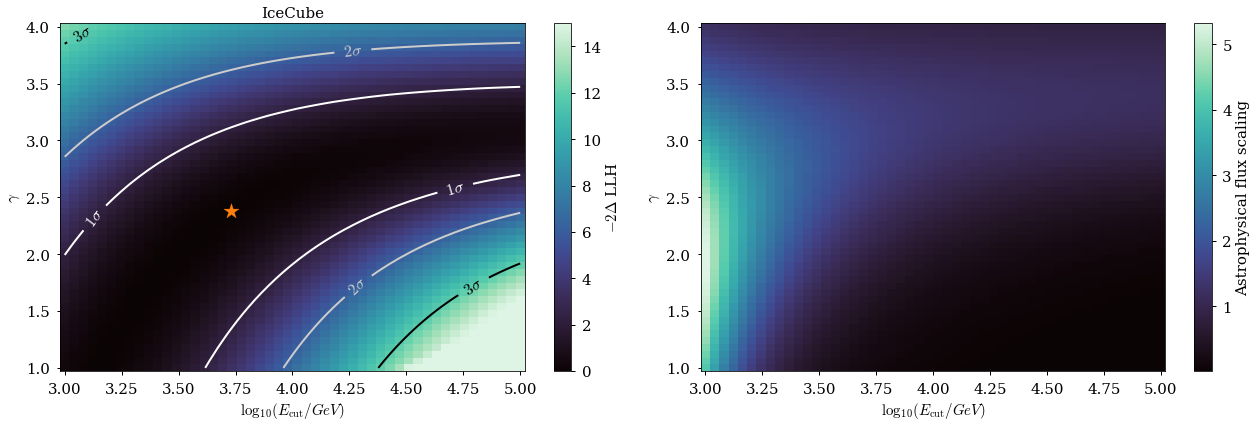

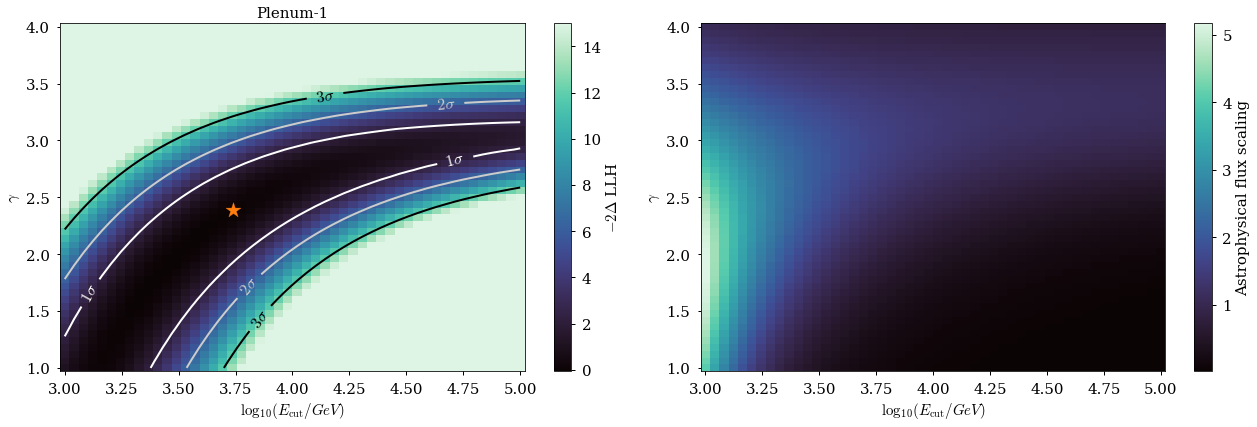

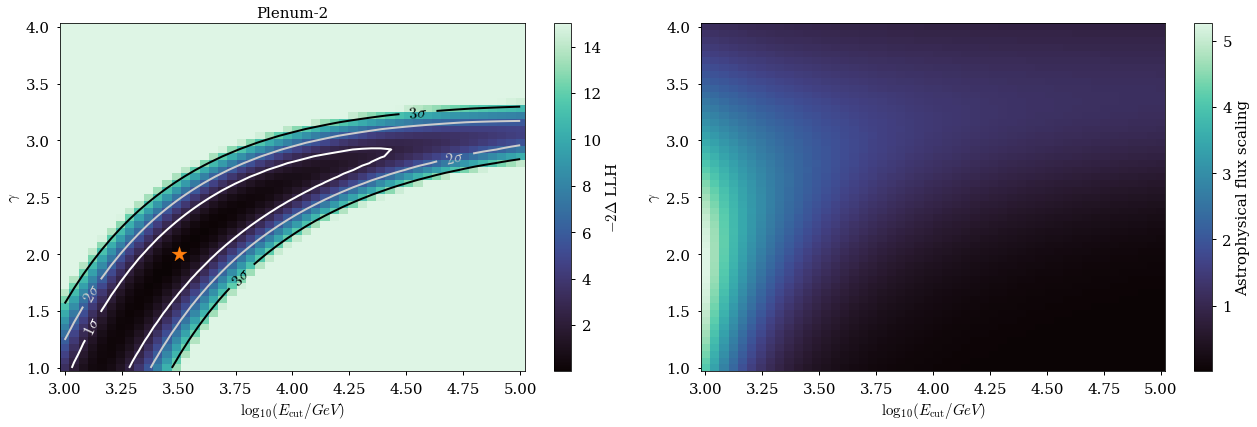

In [34]:
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["cut"][ident],
        bf_SPL["gamma"][ident],
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    # in addition, check the "nuisance" parameter of astro flux normalization
    ax = axes[1]
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["phi_astro"][ident],
    )
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


## parabola - 2D scan

IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 99.91740863596019
bf param: [1.00104327 0.69516164 4.64210294 1.15005905]
starting local fits...
WARNING!!
bf param: [2.00919163e+00 4.74294898e-07]
WARNING!!
bf param: [1.92490077e+00 1.00434316e-07]
WARNING!!
bf param: [1.17337151e+00 9.17297579e-07]
WARNING!!
bf param: [2.27202453e+00 1.11260909e-06]
WARNING!!
bf param: [1.19998852e+00 3.62478322e-09]
WARNING!!
bf param: [1.16394176e+00 2.38558137e-09]
WARNING!!
bf param: [1.19998484e+00 7.53300301e-09]
WARNING!!
bf param: [2.01128610e+00 4.78238145e-09]
WARNING!!
bf param: [1.19996945e+00 7.05959297e-10]
done
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 383.41331773092077
bf param: [1.00115883 0.66647997 4.53885667 1.16674974]
starting local fits...
WARNING!!
bf param: [ 1.19987027 -0.94999999]
WARNING!!
bf param: [ 1.19988658 -0.94944063]
WARNING!!
bf param: [ 1.56868439 -0.45306551]
WARNING!!
bf param: [ 1.20528559 -0.94316362]
WARNING!!
bf param: 

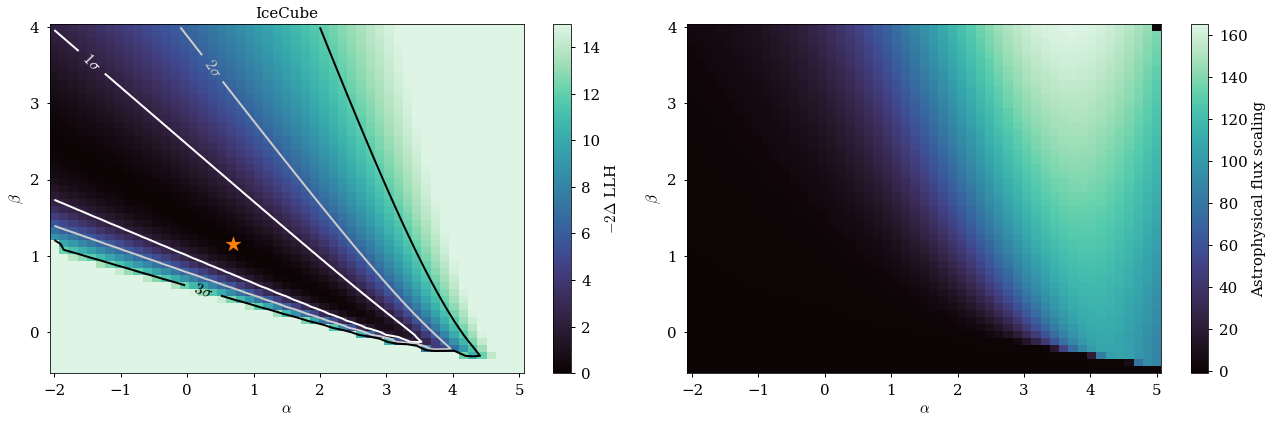

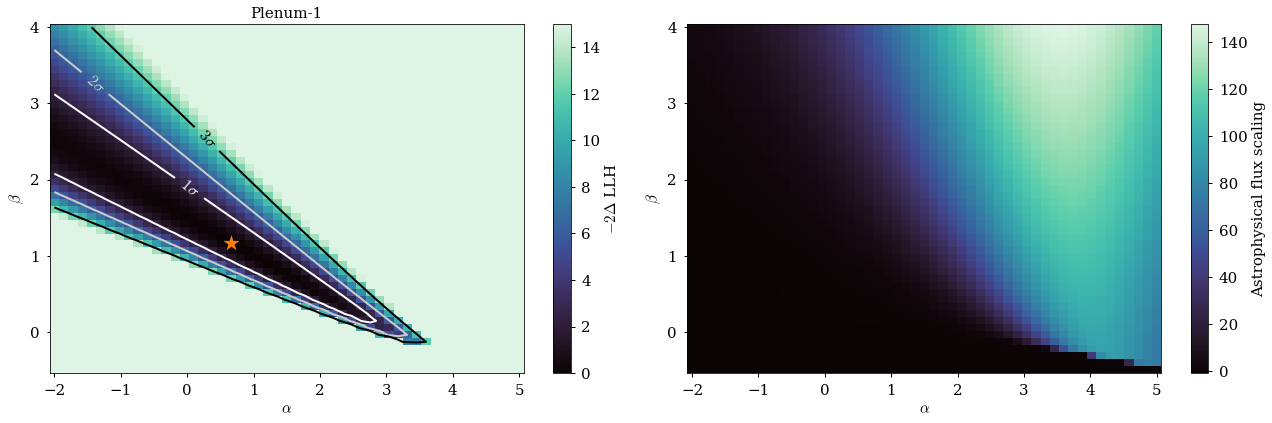

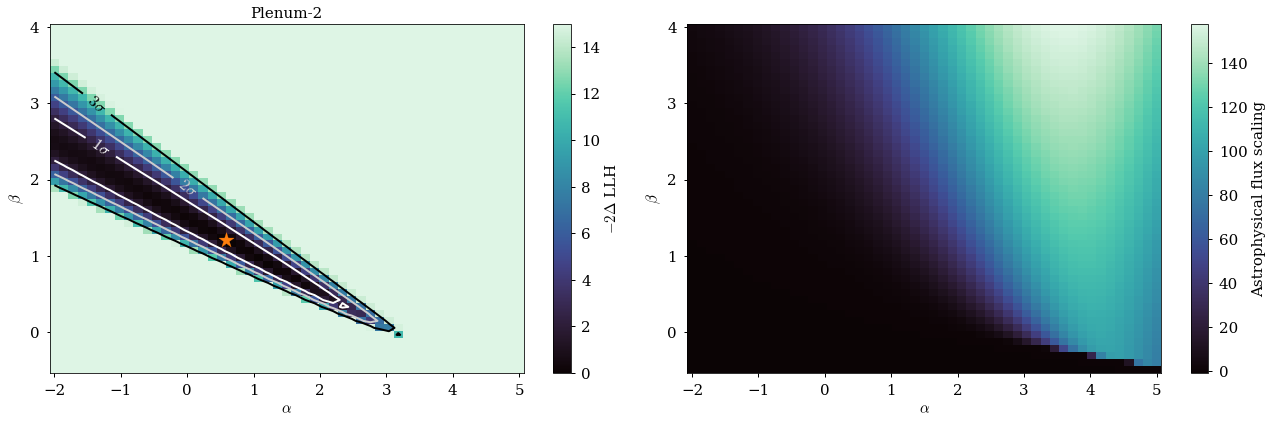

In [35]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
alpha_astro_scaling = np.linspace(-2, 5, num=num + 1)
beta_astro_scaling = np.linspace(-0.5, 4, num=num)
bf_SPL = {"ts": {}, "conv": {}, "alpha": {}, "phi_astro": {}, "beta": {}}
local_SPL = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm,
        Alpha_NGC,
        flux_scaling_para,
        Beta_NGC,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    comp = lambda x: ps_llh_2d_composite(x, mu_b_base, mu_s_base, k_i, e_0=E_para_norm, shape="parabola")
    out = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.2, 0.05, 2.2),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["alpha"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    bf_SPL["beta"][ident] = out[0][3]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    local_SPL["phi_astro"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, bsc in enumerate(beta_astro_scaling):
        for j, asc in enumerate(alpha_astro_scaling):
            func = lambda x: ps_llh_2d_composite((x[0], asc, x[1], bsc), mu_b_base, mu_s_base, k_i, e_0=E_para_norm, shape="parabola")
            local_out = fmin_l_bfgs_b(
                func,
                x0=(1.2, 0.05),
                #bounds=[(0.1, 3), (0.005, 0.2)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL["conv"][ident][i][j] = local_out[0][0]
            local_SPL["phi_astro"][ident][i][j] = local_out[0][1]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")

# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        alpha_astro_scaling,
        beta_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        alpha_astro_scaling,
        beta_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["alpha"][ident],
        bf_SPL["beta"][ident],
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"$\beta$")
    ax.set_xlabel(r"$\alpha$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    # in addition, check the "nuisance" parameter of astro flux normalization
    ax = axes[1]
    im = ax.pcolormesh(
        alpha_astro_scaling,
        beta_astro_scaling,
        local_SPL["phi_astro"][ident],
    )
    ax.set_ylabel(r"$\beta$")
    ax.set_xlabel(r"$\alpha$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


# Cutoff significance versus time/detectors

Some options:
* 10yr IceCube
* 20yr IceCube
* 40yr IceCube
* 10yr IceCube + K3N
* 10yr IceCube + K3N + GVD
* 10yr IceCube + K3N + GVD + PONE
* 10yr IceCube +  2yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  5yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube + 10yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  2yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube +  5yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube + 10yr Plenum-2 (= GEN2 + PONE + GVD + K3N)

In [36]:
# livetime relative to 10yrs
detector_configurations = [
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC",
    },
    {
        "IceCube": 2.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "20y IC",
    },
    {
        "IceCube": 4.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "40y IC",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0.2,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 2y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0.5,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 5y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 1,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 10y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0.2,
        "Plenum-1": 0,
        "KM3NeT": 0.2,
        "P-ONE": 0.2,
        "Baikal-GVD": 0.2,
        "identifier": "10y IC + 2y PL-2",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0.5,
        "Plenum-1": 0,
        "KM3NeT": 0.5,
        "P-ONE": 0.5,
        "Baikal-GVD": 0.5,
        "identifier": "10y IC + 5y PL-2",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 1,
        "Plenum-1": 0,
        "KM3NeT": 1,
        "P-ONE": 1,
        "Baikal-GVD": 1,
        "identifier": "10y IC + 10y PL-2",
    },
]
detector_configurations = pd.DataFrame(detector_configurations)


In [37]:
pvals = []
shape = "powerlaw with cutoff"

for idx, series in detector_configurations.iterrows():
    print(idx)
    aeff_factor = np.zeros_like(aeff_2d["IceCube"].T)
    naming = ""
    for ident, lt_factor in series.items():
        if ident == "identifier":
            continue
        if lt_factor == 0:
            continue
        print(ident)
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width)
            * LIVETIME
            * lt_factor
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    # check that the TS at the fit minimum is close to the TS of the baseline params
    baseline_ts_check = np.isclose(
        out[1],
        spectral_ts_func(
            shape_params[shape]["baseline"], aeff_factor, emids, E_NORM, k_i, shape
        ),
        rtol=1e-2,
    )
    print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
    # best fit powerlaw as null hypothesis
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        bounds=shape_params["powerlaw"]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
    )
    pval = chi2.sf(out_pl[1] - out[1], 1)
    sigma = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", sigma)
    pvals.append(
        {
            "identifier": series.identifier,  # str(idx) + ", " +
            "idx": idx,
            "pval": pval,
            r"Significance in $\sigma$": sigma,
        }
    )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


0
IceCube


NameError: name 'asimov_data' is not defined

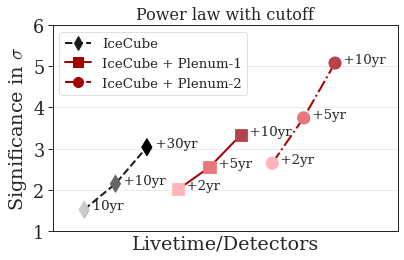

In [ ]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
    marker="d",
    label="IceCube",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)
ax.text(
    x=pval_df.loc[0]["identifier"],
    y=pval_df.loc[0][r"Significance in $\sigma$"],
    s="  10yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[1]["identifier"],
    y=pval_df.loc[1][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[2]["identifier"],
    y=pval_df.loc[2][r"Significance in $\sigma$"],
    s="  +30yr",
    fontsize=label_size,
)

## PLENUM-1
ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
    marker="s",
    label="IceCube + Plenum-1",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)
ax.text(
    x=pval_df.loc[3]["identifier"],
    y=pval_df.loc[3][r"Significance in $\sigma$"],
    s="  +2yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[4]["identifier"],
    y=pval_df.loc[4][r"Significance in $\sigma$"],
    s="  +5yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[5]["identifier"],
    y=pval_df.loc[5][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)


## PLENUM-2
ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
    marker="o",
    label="IceCube + Plenum-2",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)
ax.text(
    x=pval_df.loc[6]["identifier"],
    y=pval_df.loc[6][r"Significance in $\sigma$"],
    s="  +2yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[7]["identifier"],
    y=pval_df.loc[7][r"Significance in $\sigma$"],
    s="  +5yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[8]["identifier"],
    y=pval_df.loc[8][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)

ax.set_xlim(-1, 10)
ax.set_ylim(1, 6)
ax.set_xticks([])
ax.legend(fontsize="x-small")
ax.set_title("Power law with cutoff", fontsize="small")
ax.set_xlabel("Livetime/Detectors")
ax.set_ylabel(r"Significance in $\sigma$")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det_talk.pdf")


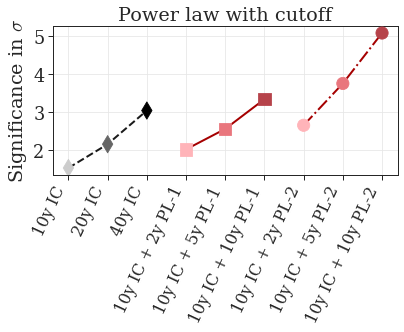

In [ ]:
# same plot, alternative labeling as in PoS(ICRC2021)1185
f, ax = plt.subplots(figsize=(6, 5))

ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)


# ax.set_ylim(0, 5.5)
ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"Significance in $\sigma$")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det.pdf")


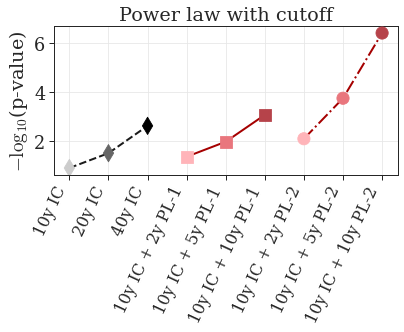

In [ ]:
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)

ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"$-\log_{10}$(p-value)")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_det.pdf")


## Significance vs cutoff value

In [ ]:
print_names = {
    "IceCube": "IceCube",
    "Plenum-1": r"IceCube + PLE$\nu$M-1",
    "Plenum-2": r"IceCube + PLE$\nu$M-2",
}


In [ ]:
pvals = []
cutoff_vals = np.round(np.arange(5.0, 8.1, step=0.2), 1)
for e_cut in cutoff_vals:
    for li, ident in enumerate(idents):
        shape = "powerlaw with cutoff"
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        if "Plenum" in ident:
            aeff_factor += (
                aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
                * LIVETIME
            )
        # asimov = expectation of perfect experiment
        shp_params = np.copy(shape_params[shape]["baseline"])
        shp_params[-1] = e_cut
        k_i = asimov_data(aeff_factor, shape, verbose=False, shp_params=shp_params)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape),
        )
        # check that the TS at the fit minimum is close to the TS of the baseline params
        reference = spectral_ts_func(shp_params, aeff_factor, emids, E_NORM, k_i, shape)
        baseline_ts_check = np.isclose(out[1], reference, rtol=1e-2)
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        if not baseline_ts_check:
            print("e_cut:", shp_params[-1])
            print("fit: ", out[1], ", reference:", reference)
        # best fit powerlaw as null hypothesis
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
        )
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        # print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        pvals.append(
            {
                "ident": print_names[ident],
                "pval": pval,
                r"Significance in $\sigma$": significance,
                r"$\log_{10}(E_{\rm cut}/{\rm GeV})$": e_cut,
                r"Conv_PL": out_pl[0][0],
                r"$\gamma_{PL}$": out_pl[0][1],
                r"$\Phi_{0,PL}$": out_pl[0][2],
                r"Conv": out[0][0],
                r"$\gamma$": out[0][1],
                r"$\Phi_{0}$": out[0][2],
                r"$E_{\rm cut}$": out[0][3],
            }
        )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK


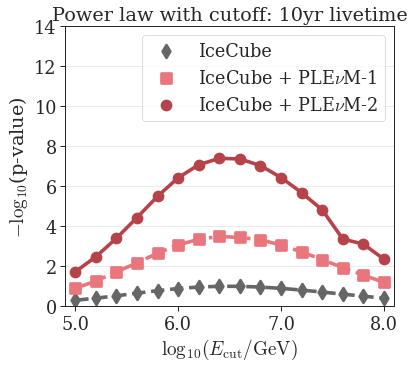

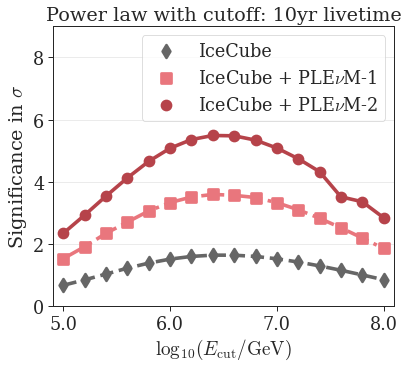

In [ ]:
f, ax = plt.subplots(figsize=(6, 5.5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$-\log_{10}$(p-value)",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 5]],
    linestyles=["--", "-.", "-"],
    markers=["d", "s", "o"],
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1)  # , fontsize="x-small")
ax.set_ylim(0, 14)
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_cutoff.pdf")

f, ax = plt.subplots(figsize=(6, 5.5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Significance in $\sigma$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 5]],
    linestyles=["--", "-.", "-"],
    markers=["d", "s", "o"],
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1)  # , fontsize="x-small")
ax.set_ylim(0, 9)
f.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_cutoff.pdf")


## check that parameter fits are ok

In [ ]:
plot_kw = dict(
    palette=many_colors[[1, 4, 5]],
    linestyles=["-", "-.", "-"],
    markers=["d", "s", "o"],
)


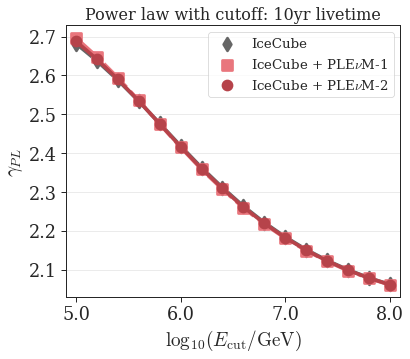

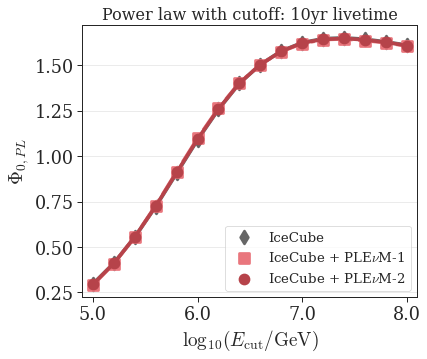

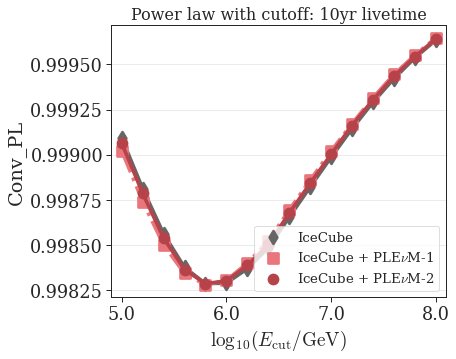

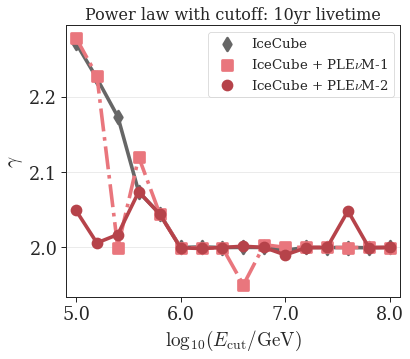

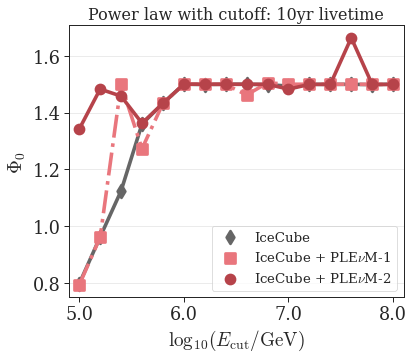

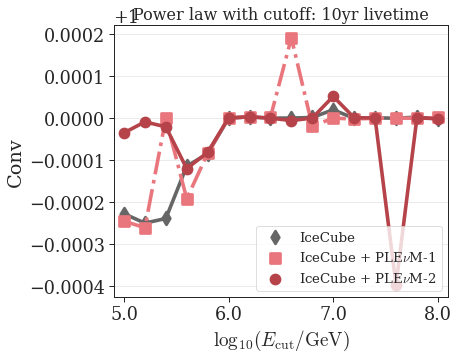

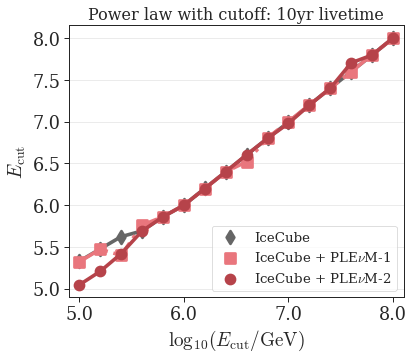

In [ ]:
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\gamma_{PL}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\Phi_{0,PL}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Conv_PL",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\gamma$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\Phi_{0}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Conv",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$E_{\rm cut}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")
